# REINFORCE with Baseline
This notebook shows one the most basic RL algorithms - [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf).  

It was tested on the `CartPole-v1` only.

In [1]:
import sys
from typing import Tuple

import gym
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F


sys.path.append("../")

from push_ups import agent_base
from push_ups.utils import default_network, training_loop

## Define Policy and the Agent
Policy can be some ML model which takes decisions based on the environment state (or the observation if the state is hidden).  
Agent defines how:
1. policy is created (`get_policy` method)
2. action are taken (`take_action` method)
3. policy is updated (`update_policy` method)

In [3]:
class PolicyAgent(agent_base.Agent):
    def __init__(self, env: gym.core.Env, gamma: float = 0.9, lr=0.003, *args, **kwargs):
        """
        :param: gamma: discount factor used to calculate return
        :param: lr: learning rate used in the torch optimizer
        """
        super().__init__(env, gamma, lr, *args, **kwargs)
        self.log_action_probabilities = []
        self.baseline = self.get_baseline()
        
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.baseline_optimizer = torch.optim.Adam(self.baseline.parameters(), lr=lr)
    
    def get_policy(self) -> nn.Module:
        inputs_no = self.get_observations()
        outputs_no = self.get_actions()
        discrete_outputs = self.discrete_actions
        return default_network.Policy(inputs_no, outputs_no, discrete_outputs)
    
    def get_baseline(self) -> nn.Module:
        inputs_no = self.get_observations()
        outputs_no = 1
        discrete_outputs = False
        return default_network.Policy(inputs_no, outputs_no, discrete_outputs)
    
    def calculate_returns(self, rewards: torch.tensor) -> torch.tensor:
        returns = torch.flip(rewards, [0])
        for idx, item in enumerate(returns):
            if idx == 0:
                continue
            returns[idx] = item + self.gamma * returns[idx - 1]
        return torch.flip(returns, [0])
    
    
    
    
    def take_action(self, observation: np.array, *args, **kwargs):
        del args, kwargs  # unused
        if not self.discrete_actions:
            raise NotImplementedError

        observation = torch.from_numpy(observation).float().unsqueeze(0)
        probabilities = self.policy(observation)

        m = Categorical(probabilities)
        action = m.sample()
        log_prob = m.log_prob(action)
        self.log_action_probabilities.append(log_prob)

        return action.item()    
    

 
    def update_policy(self, observations: torch.tensor, rewards: torch.tensor, *args, **kwargs):
        """Update policy AND THE BASELINE!"""
        del args, kwargs  # unused             

        eps = np.finfo(np.float32).eps.item()

        returns = self.calculate_returns(rewards)

        policy_loss = []
        self.baseline_optimizer.zero_grad()
        
        output_return = self.baseline(observations[:-1,:]).float()
        criterion = nn.MSELoss()

        baseline_loss = criterion(output_return, returns)
        
        baseline_loss.backward()
        self.baseline_optimizer.step()
        
        for log_prob, R, predicted_R in zip(self.log_action_probabilities, returns, self.baseline(observations[:-1,:]).float()):
            delta = R - predicted_R
            policy_loss.append(-log_prob * delta)

        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        


        del self.log_action_probabilities[:]


In [4]:
    def calculate_returns_(rewards: torch.tensor) -> torch.tensor:
        returns = torch.flip(rewards, [0])
        for idx, item in enumerate(returns):
            if idx == 0:
                continue
            returns[idx] = item + 0.9 * returns[idx - 1]
        return torch.flip(returns, [0])
    

In [5]:
net = default_network.Policy(4, 1, False)
opt = torch.optim.Adam(net.parameters(), lr=0.01)

## Define the environmnet and the agent

In [7]:
env = gym.make("CartPole-v1")
agent = PolicyAgent(env, gamma=0.9, lr=0.01)

## Run training

In [8]:
def run_episode(
    agent: agent_base.Agent, env: gym.Env
) -> Tuple[agent_base.Agent, torch.Tensor, torch.Tensor]:
    """
    Perform one simulation (episode) to collect data for the policy update.
    """
    obs = env.reset()
    rewards = torch.Tensor(0, 1).float()
    observations = torch.Tensor(obs).view(1, -1).float()

    for t in range(1, 10000):  # Don't infinite loop while learning
        action = agent(obs)
        obs, reward, done, _ = env.step(action)
        rewards = torch.cat([rewards, torch.tensor(reward).view(1, 1)])
        observations = torch.cat([observations, torch.tensor(obs).view(1, -1).float()])

        if done:
            break

    return agent, rewards, observations

In [9]:
episode_rewards_dict = {} 
running_rewards_dict = {}

for t in range(10):
    print(t)
    agent = PolicyAgent(env, gamma=0.9, lr=0.01)
    running_reward = None
    episode_rewards = []
    running_rewards = []


    for i_episode in range(4000):
        agent, rewards, observations = run_episode(agent, env)
        ep_reward = rewards.sum().item()

        if running_reward is None:
            running_reward = ep_reward
        else:
            running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

        episode_rewards.append(ep_reward)
        running_rewards.append(running_reward)

        if running_reward > env.spec.reward_threshold:
            break

        agent.update_policy(observations, rewards)
        if i_episode % 50 == 0:
            
            print(i_episode, running_reward, ep_reward)
    episode_rewards_dict[t] = episode_rewards
    running_rewards_dict[t] = running_rewards

    

0
0 32.0 32.0 tensor(64.2915, grad_fn=<MseLossBackward>)
50 44.58354096723695 26.0 tensor(10.4869, grad_fn=<MseLossBackward>)
100 108.10885160931764 68.0 tensor(5.6529, grad_fn=<MseLossBackward>)
150 125.28936349803281 159.0 tensor(6.3034, grad_fn=<MseLossBackward>)
200 183.8076129290991 450.0 tensor(4.3995, grad_fn=<MseLossBackward>)
250 214.25623966134995 127.0 tensor(2.7859, grad_fn=<MseLossBackward>)
300 182.3162305800893 369.0 tensor(3.9033, grad_fn=<MseLossBackward>)
350 341.16179860310405 185.0 tensor(2.9184, grad_fn=<MseLossBackward>)
400 104.40153292563753 54.0 tensor(3.8516, grad_fn=<MseLossBackward>)
450 98.39278468452211 86.0 tensor(5.8106, grad_fn=<MseLossBackward>)
500 162.72322869662653 177.0 tensor(3.6110, grad_fn=<MseLossBackward>)
550 139.05007492545784 118.0 tensor(3.1565, grad_fn=<MseLossBackward>)
600 124.58004130087419 133.0 tensor(2.8584, grad_fn=<MseLossBackward>)
650 199.48042684481314 180.0 tensor(2.8700, grad_fn=<MseLossBackward>)
700 230.14824026543357 369.0

In [10]:
import pickle
res = [episode_rewards_dict, running_rewards_dict]
with open('REINFORCE_with_baseline.pickle', 'wb') as handle:
    pickle.dump(res, handle)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def setup_plot(ax):
    ax.set_xlim(0, 4000)
    ax.set_ylim(0, 500)
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Score')

    ax.legend()


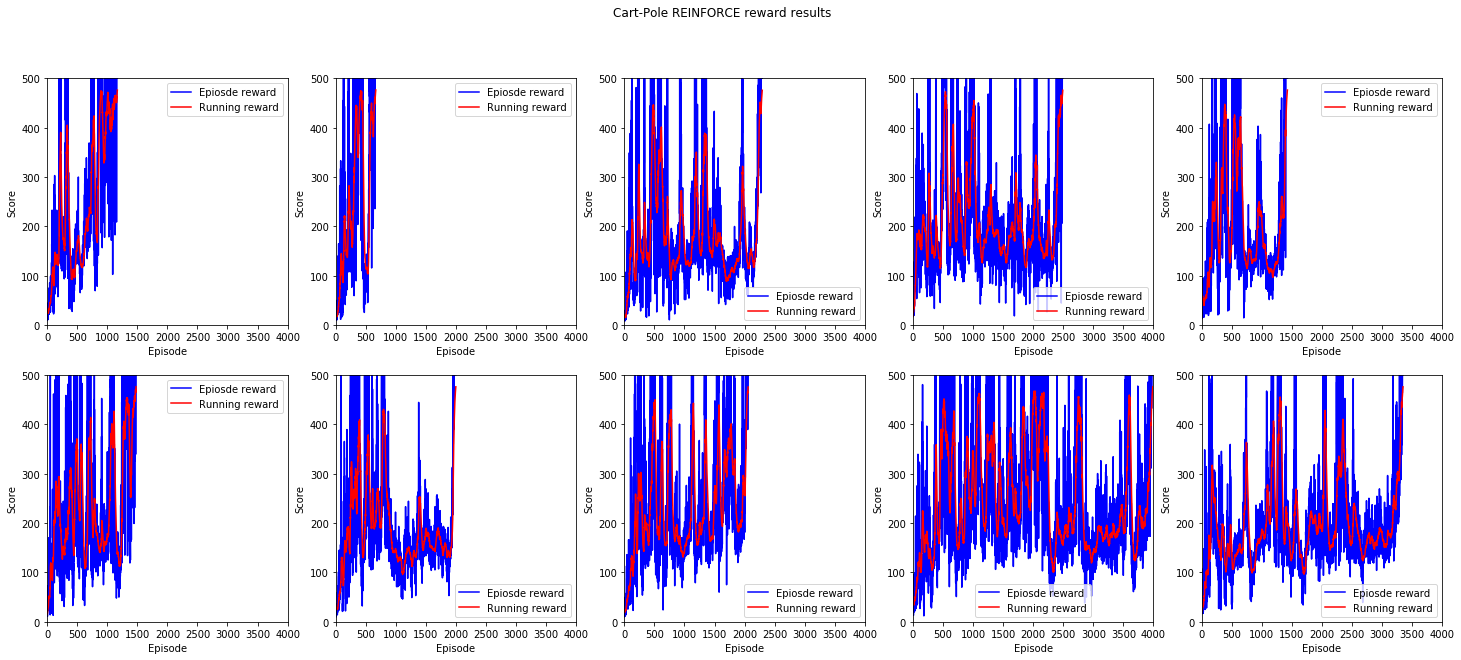

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle("Cart-Pole REINFORCE reward results")
for y in range(2):
    for x in range(5):
        
        sample = y * 5 + x

        x_epiosde_reward = range(len(episode_rewards_dict[sample]))
        y_epiosde_reward = episode_rewards_dict[sample]

        x_running_reward = range(len(running_rewards_dict[sample]))
        y_running_reward = running_rewards_dict[sample]

        axs[y][x].plot(x_epiosde_reward, y_epiosde_reward, 'b', label="Epiosde reward")
        axs[y][x].plot(x_running_reward, y_running_reward, 'r', label="Running reward")


        setup_plot(axs[y][x])

plt.show()

## See the results

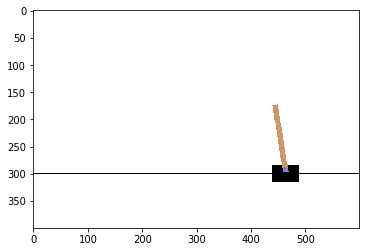

In [5]:
obs = env.reset()

img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for i in range(300):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    action = agent(obs)
    obs, rew, done, info = env.step(action)
    
    if done:
        break

In [36]:
a = 1

In [133]:
a = 1 + 0.9 * a
a

9.999672081495216